In [5]:
import os
import pandas as pd
import re
from tqdm import tqdm
from utils import load_jsonl_iteratively


iter_losses = []
lang = "en"

if lang == "ja":
    task_names = {
        'ja_knowledge_memorization': 'Memorization',
        'ja_knowledge_generalization': 'Intralingual',
        'en_knowledge_generalization': 'Interlingual'
    }
    ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-ja/hf_models"
else:
    task_names = {
        'en_knowledge_memorization': 'Memorization',
        'en_knowledge_generalization': 'Intralingual',
        'ja_knowledge_generalization': 'Interlingual'
    }
    ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-en_jstage/hf_models"

In [6]:
examples = {}
for fn in tqdm(os.listdir(ROOT)):
    if not fn.startswith("iter_"):
        continue

    iter_info = {task: [] for task in task_names}
    num_iter = int(re.match("iter_(\d+)", fn).group(1))
    if num_iter > 0 and num_iter < 1000:
        continue
    
    fn = os.path.join(ROOT, fn, "adaxeval.jsonl")
    if not os.path.exists(fn):
        continue
    
    task2sample_ids = {task: set() for task in task_names}
    for item in load_jsonl_iteratively(fn):
        sample = item['sample']
        if 'dataset' not in sample:
            continue
        task = sample['dataset']
        if task not in task_names:
            continue
        
        sample_id = sample['sample_id']
        if sample_id in task2sample_ids[task]:
            continue
        
        task2sample_ids[task].add(sample_id)

        answer_idx = int(sample['answer_idx'])
        valid_loss = item['losses'][answer_idx]
        valid_normloss = item['norm_losses'][answer_idx]
        invalid_loss = sum([item['losses'][i] for i in range(4) if i != answer_idx])/3
        invalid_normloss = sum([item['norm_losses'][i] for i in range(4) if i != answer_idx])/3

        iter_info[task].append((sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss))

    for task, losses in iter_info.items():
        sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss = list(zip(*losses))
        iter_losses.append({
            'sample_id': sample_id,
            'num_iter': num_iter,
            'task': task_names[task],
            'valid_loss': sum(valid_loss)/len(valid_loss),
            'valid_normloss': sum(valid_normloss)/len(valid_normloss),
            'invalid_loss': sum(invalid_loss)/len(invalid_loss),
            'invalid_normloss': sum(invalid_normloss)/len(invalid_normloss),
            'valid_loss_ratio': sum(valid_loss) / (sum(valid_loss) + 3 * sum(invalid_loss)),
            'valid_normloss_ratio': sum(valid_normloss) / (sum(valid_normloss) + 3 * sum(invalid_normloss)),
            'num_sample': len(losses),
        })
df = pd.DataFrame(iter_losses)
df = df[(df['num_iter'] >= 1000) | (df['num_iter'] == 0)]

100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


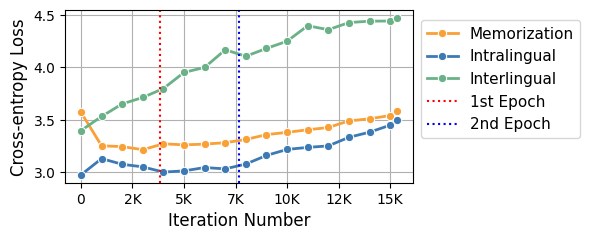

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fontsize=12
plt.figure(figsize=(6, 2.5))
sns.lineplot(
    data=df, x='num_iter', y='valid_normloss', 
    hue='task', linewidth=2, marker="o", 
    palette={'Memorization': '#F9A037', 'Intralingual': '#3D7AB3', 'Interlingual': '#6AB187'})
plt.xlabel("Iteration Number", fontsize=fontsize)
plt.ylabel("Cross-entropy Loss", fontsize=fontsize)

plt.axvline(x=int(max(df['num_iter'])/4), color='#FF0000', linestyle='dotted', label='1st Epoch')
plt.axvline(x=int(max(df['num_iter'])/2), color='#0000FF', linestyle='dotted', label='2nd Epoch')
plt.grid(True)

def thousands_formatter(x, pos):
    if x == 0: return '0'
    else:
        return f'{int(x / 1000)}K'
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6), fontsize=11)
plt.tight_layout()
# plt.show()
result_dir = "../figures"
plt.savefig(
    os.path.join(result_dir, f"{lang}-adaxeval-loss.pdf"), 
    dpi=300, bbox_inches="tight")


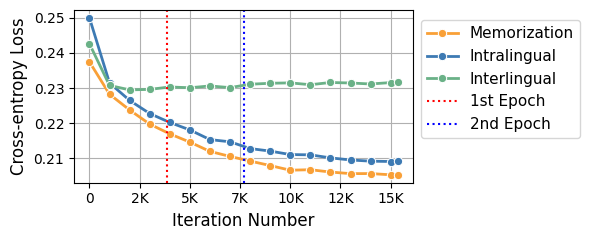

In [8]:
fontsize=12
plt.figure(figsize=(6, 2.5))
sns.lineplot(
    data=df, x='num_iter', y='valid_normloss_ratio', 
    hue='task', linewidth=2, marker="o", 
    palette={'Memorization': '#F9A037', 'Intralingual': '#3D7AB3', 'Interlingual': '#6AB187'})
plt.xlabel("Iteration Number", fontsize=fontsize)
plt.ylabel("Cross-entropy Loss", fontsize=fontsize)

plt.axvline(x=int(max(df['num_iter'])/4), color='#FF0000', linestyle='dotted', label='1st Epoch')
plt.axvline(x=int(max(df['num_iter'])/2), color='#0000FF', linestyle='dotted', label='2nd Epoch')
plt.grid(True)

def thousands_formatter(x, pos):
    if x == 0: return '0'
    else:
        return f'{int(x / 1000)}K'
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6), fontsize=11)
plt.tight_layout()
# plt.show()
result_dir = "../figures"
plt.savefig(
    os.path.join(result_dir, f"{lang}-adaxeval-loss-ratio.pdf"), 
    dpi=300, bbox_inches="tight")
